In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import os.path

In [5]:
import sys  
sys.path.insert(0, '../baselines')
from baselines.common.atari_wrappers import make_atari, wrap_deepmind

In [6]:
plt.style.use('fivethirtyeight')

In [7]:
env_id="PongNoFrameskip-v4"
env=make_atari(env_id)
env=wrap_deepmind(env)

In [8]:
import time

In [9]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [10]:
import gym

In [11]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:5" if use_cuda else "cpu")

In [12]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 10000
gamma=0.99
#gamma=0.85
egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 10000

report_interval=10

score_to_solve = 18.0

hidden_layer_size=512

replay_memory_size=100000

batch_size=32

update_target_frequency = 5000

clip_error=True
normalize_image=True

double_dqn=True

file2save = 'pong_save_funny_mean_lr0.02.pth'

save_model_frequency=10000

resume_previous_training=False

In [13]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
env = gym.wrappers.Monitor(env, '../mp4/PongVideos_funny_mean_lr0.01',video_callable=lambda episode_id: episode_id%20==0, force=True)

In [14]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [15]:
env.observation_space.shape

(84, 84, 1)

In [16]:
env.action_space.n

6

In [17]:
env.action_space.contains

<bound method Discrete.contains of Discrete(6)>

In [18]:
env.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [19]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [20]:
def load_model():
    return torch.load(file2save)

def save_model(model):
    torch.save(model.state_dict(), file2save)

In [21]:
def preprocess_frame(frame):
    frame = frame.transpose((2,0,1))
    frame = torch.from_numpy(frame)
    frame = frame.to(device, dtype=torch.float32)
    frame = frame.unsqueeze(0)
    return frame

In [22]:
def plot_results():
    plt.figure(figsize=[12,5])
    plt.title("Score at end of episode")
    plt.plot(reward_total[:i_episode],color='red')
    plt.savefig("Pong-results-funny_mean_lr0.01.png")
    plt.close()
    

In [23]:
o=torch.arange(20,dtype=torch.float32).view(-1,5)
print(o)

tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.],
        [15., 16., 17., 18., 19.]])


In [24]:
o.shape

torch.Size([4, 5])

In [25]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            transition=(state,action,new_state,reward,done)
            
            if self.position>=len(self.memory):
                self.memory.append(transition)
            else:
                self.memory[self.position]=transition
                
            self.position=(self.position+1)%self.capacity
        
    
    def sample(self,batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    

In [26]:
class NeuralNetworkDueling(nn.Module):
    def __init__(self):
        super(NeuralNetworkDueling, self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8 ,stride=4)
        self.conv2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4 ,stride=2)
        self.conv3=nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3 ,stride=1)
        
        self.advantage1 = nn.Linear(7*7*64, hidden_layer_size)
        self.advantage2 = nn.Linear(hidden_layer_size, number_of_outputs)
        
        self.value1 = nn.Linear(7*7*64,hidden_layer_size)
        self.value2 = nn.Linear(hidden_layer_size,1)
        
        #self.activation=nn.Tanh()
        self.activation=nn.ReLU()
        
    def forward(self, x):
        
        #print('x shape {} and value:'.format(x.shape))
        #print(x.detach().cpu())
        
        if normalize_image:
            x=x/255.0
        
        output_conv = self.conv1(x)
        output_conv = self.activation(output_conv)
        output_conv = self.conv2(output_conv)
        output_conv = self.activation(output_conv)
        output_conv = self.conv3(output_conv)
        output_conv = self.activation(output_conv)
        
        output_conv = output_conv.view(output_conv.shape[0],-1)
        
        output_advantage=self.advantage1(output_conv)
        output_advantage=self.activation(output_advantage)
        output_advantage=self.advantage2(output_advantage)
        
        output_value=self.value1(output_conv)
        output_value=self.activation(output_value)
        output_value=self.value2(output_value)
        
        #print('output_advantage shape {} and value:'.format(output_advantage.shape))
        #print(output_advantage.detach().cpu())
        
        #print('output_value shape {} and value:'.format(output_value.shape))
        #print(output_value.detach().cpu())
        
        #print('output_advantage.mean shape {} and value:'.format(output_advantage.mean(dim=1,keepdim=True).shape))
        #print(output_advantage.mean(dim=1,keepdim=True).detach().cpu())
        
        output_final = output_value + output_advantage - output_advantage.mean()
        
        #output_final=output_value+output_advantage-output_advantage.mean(dim=1,keepdim=True)
        
        
        return output_final

In [27]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [28]:
class QNet_Agent():
    def __init__(self):
        
        self.nn = NeuralNetworkDueling().to(device)
        self.target_nn = NeuralNetworkDueling().to(device)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        self.number_of_frames = 0
        
        if resume_previous_training and os.path.exists(file2save):
            print('loading previous model')
            self.nn.load_state_dict(load_model())
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=preprocess_frame(state)
                #state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state).squeeze()
                #print('predicted value from nn:')
                #print(predicted_value_from_nn)
                action=torch.argmax(predicted_value_from_nn).item()
                #print('action: {}'.format(action))
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state=[preprocess_frame(frame) for frame in state] 
        state=torch.cat(state)
        
        new_state=[preprocess_frame(frame) for frame in new_state] 
        new_state=torch.cat(new_state)
        
        #print('state batch shape {}'.format(state.shape))
        #print(state)
        
        #state=torch.Tensor(state).to(device)
        #new_state=torch.Tensor(new_state).to(device)
        
        
        reward=torch.Tensor(reward).to(device)
        
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        self.nn.eval()
        self.target_nn.eval()
            
            
        if double_dqn:
            #print('in double DQN')
            new_state_values_from_nn=self.nn(new_state).detach()
            #print('new_state_values_from_nn shape {} and value:'.format(new_state_values_from_nn.shape))
            #print(new_state_values_from_nn)
            max_new_state_indexes=torch.max(new_state_values_from_nn,dim=1)[1].view(-1,1)
            #print('max_new_state_indexes shape {} and value:'.format(max_new_state_indexes.shape))
            #print(max_new_state_indexes)
            new_state_values=self.target_nn(new_state).detach()
            #print('new_state_values shape {} and value:'.format(new_state_values.shape))
            #print(new_state_values)
            max_new_state_values=torch.gather(new_state_values,1,max_new_state_indexes).squeeze()
            #print('max_new_state_values shape {} and value:'.format(max_new_state_values.shape))
            #print(max_new_state_values)
        else:
            #print('in regular DQN')
            new_state_values=self.target_nn(new_state).detach()
            #print('new_state_values shape {} and value'.format(new_state_values.shape))
            #print(new_state_values)
        
            max_new_state_values=torch.max(new_state_values,dim=1)[0]
            #print('max_new_state_values shape {} and value'.format(max_new_state_values.shape))
            #print(max_new_state_values)
            
        target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
        #print('shape of: target_value')
        #print(target_value.shape)
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.clamp_(-1.0,1.0)
        
        self.optimizer.step()
        
        if self.number_of_frames % update_target_frequency == 0:
            #print("***********************")
            #print("UPDATING TARGET NETWORK")
            #print("update counter: {}".format(self.update_target_counter))
            #print("***********************")
            self.target_nn.load_state_dict(self.nn.state_dict())
            
        if self.number_of_frames % save_model_frequency ==0:
            save_model(self.nn)
        
        self.number_of_frames+=1
        

In [29]:
memory=ExperienceReplay(replay_memory_size)

In [30]:
qnet_agent=QNet_Agent()

In [31]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [32]:
%%time

steps_total=np.full([num_episodes],-999,dtype=np.int32)
reward_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    reward_total[i_episode]=0
    
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state,
                     reward, done)
        
        reward_total[i_episode]+=reward
        
        qnet_agent.optimize()
        
        state=new_state
        
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(reward_total[i_episode-100:i_episode])/100
                
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                
                plot_results()
                
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(reward_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(reward_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: -20.2
Average over all episodes so far: -20.2
epsilon: 0.330320309621247
**** Episode  20 **** 
Recent average reward: -20.8
Average over all episodes so far: -20.5
epsilon: 0.14871499919168618
**** Episode  30 **** 
Recent average reward: -20.9
Average over all episodes so far: -20.633333333333333
epsilon: 0.07149288411839806
**** Episode  40 **** 
Recent average reward: -21.0
Average over all episodes so far: -20.725
epsilon: 0.037064460937615035
**** Episode  50 **** 
Recent average reward: -20.8
Average over all episodes so far: -20.74
epsilon: 0.02205188962175885
**** Episode  60 **** 
Recent average reward: -21.0
Average over all episodes so far: -20.783333333333335
epsilon: 0.015496554617284664
**** Episode  70 **** 
Recent average reward: -20.9
Average over all episodes so far: -20.8
epsilon: 0.01248835403735595
**** Episode  80 **** 
Recent average reward: -21.0
Average over all episodes so far: -20.825
epsilon: 0.01110574737380251

**** Episode  540 **** 
Recent average reward: -20.9
Reward over last 100: -20.83
Average over all episodes so far: -20.877777777777776
epsilon: 0.01
**** Episode  550 **** 
Recent average reward: -20.4
Reward over last 100: -20.78
Average over all episodes so far: -20.869090909090907
epsilon: 0.01
**** Episode  560 **** 
Recent average reward: -20.7
Reward over last 100: -20.77
Average over all episodes so far: -20.866071428571427
epsilon: 0.01
**** Episode  570 **** 
Recent average reward: -21.0
Reward over last 100: -20.78
Average over all episodes so far: -20.86842105263158
epsilon: 0.01
**** Episode  580 **** 
Recent average reward: -20.9
Reward over last 100: -20.78
Average over all episodes so far: -20.868965517241378
epsilon: 0.01
**** Episode  590 **** 
Recent average reward: -21.0
Reward over last 100: -20.79
Average over all episodes so far: -20.871186440677967
epsilon: 0.01
**** Episode  600 **** 
Recent average reward: -20.9
Reward over last 100: -20.8
Average over all epi

**** Episode  1100 **** 
Recent average reward: -20.9
Reward over last 100: -20.85
Average over all episodes so far: -20.863636363636363
epsilon: 0.01
**** Episode  1110 **** 
Recent average reward: -20.8
Reward over last 100: -20.85
Average over all episodes so far: -20.863063063063063
epsilon: 0.01
**** Episode  1120 **** 
Recent average reward: -20.8
Reward over last 100: -20.83
Average over all episodes so far: -20.8625
epsilon: 0.01
**** Episode  1130 **** 
Recent average reward: -20.9
Reward over last 100: -20.83
Average over all episodes so far: -20.86283185840708
epsilon: 0.01
**** Episode  1140 **** 
Recent average reward: -20.8
Reward over last 100: -20.83
Average over all episodes so far: -20.862280701754386
epsilon: 0.01
**** Episode  1150 **** 
Recent average reward: -20.8
Reward over last 100: -20.84
Average over all episodes so far: -20.86173913043478
epsilon: 0.01
**** Episode  1160 **** 
Recent average reward: -20.7
Reward over last 100: -20.81
Average over all episode

KeyboardInterrupt: 

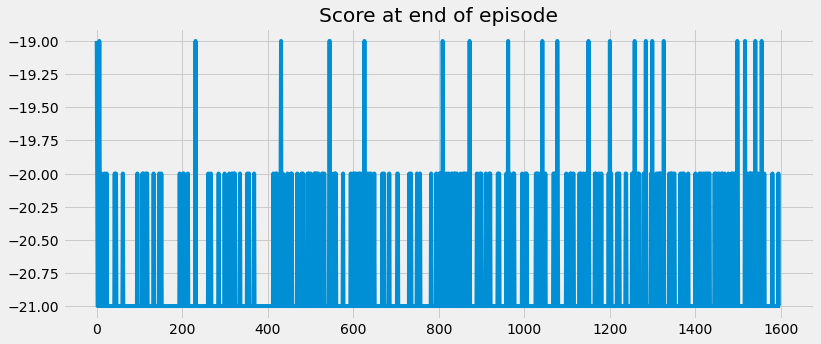

In [33]:
plt.figure(2,figsize=[12,5])
plt.title("Score at end of episode")
plt.plot(reward_total[:i_episode])
plt.show()

In [34]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: -709.8887


In [35]:
print("Average number of steps: {}". format(np.average(steps_total)))
print("Average number of steps in last 100 episodes: {}". format(np.average(steps_total[-100:])))



Average number of steps: -709.8887
Average number of steps in last 100 episodes: -999.0


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

In [36]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(:i_episode)
plt.show()

SyntaxError: invalid syntax (<ipython-input-36-8a920a9d06e8>, line 3)